In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tabulate import tabulate
from sklearn.linear_model import Lasso
import mlflow
from sklearn.linear_model import SGDRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

path = 'datasets/LEAF_LEVEL_DATASET_Yufeng_Ge.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])

/home/ubuntu/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [8]:
X =df.get(0)
X = (X.iloc[:,14:]).values
print(X.shape)
print(X)

(2905, 2151)
[[0.10534241 0.12494414 0.10755504 ... 0.03171077 0.0314088  0.03064385]
 [0.08744413 0.11408205 0.1255238  ... 0.05223024 0.05225496 0.05238018]
 [0.09524734 0.11283996 0.10805123 ... 0.04718012 0.04704811 0.04683157]
 ...
 [0.08363266 0.09290786 0.083066   ... 0.04282517 0.04261783 0.04248545]
 [0.09348846 0.09856943 0.08780694 ... 0.04525967 0.04508637 0.04494107]
 [0.05796528 0.09717503 0.08508438 ... 0.03692887 0.03678274 0.03681707]]


OUTPUT DATA

In [4]:
Y =df.get(0)
Y = (Y.iloc[:,7]).values
print(Y.shape)

(2905,)


**LASSO with coordinate descent**

Ripartion: 0.3 - trial: 97
Ripartion: 0.3 - trial: 98
Ripartion: 0.3 - trial: 99
Param 2
Ripartion: 0.35 - trial: 0
Ripartion: 0.35 - trial: 1
Ripartion: 0.35 - trial: 2
Ripartion: 0.35 - trial: 3
Ripartion: 0.35 - trial: 4
Ripartion: 0.35 - trial: 5
Ripartion: 0.35 - trial: 6
Ripartion: 0.35 - trial: 7
Ripartion: 0.35 - trial: 8
Ripartion: 0.35 - trial: 9
Ripartion: 0.35 - trial: 10
Ripartion: 0.35 - trial: 11
Ripartion: 0.35 - trial: 12
Ripartion: 0.35 - trial: 13
Ripartion: 0.35 - trial: 14
Ripartion: 0.35 - trial: 15
Ripartion: 0.35 - trial: 16
Ripartion: 0.35 - trial: 17
Ripartion: 0.35 - trial: 18
Ripartion: 0.35 - trial: 19
Ripartion: 0.35 - trial: 20
Ripartion: 0.35 - trial: 21
Ripartion: 0.35 - trial: 22
Ripartion: 0.35 - trial: 23
Ripartion: 0.35 - trial: 24
Ripartion: 0.35 - trial: 25
Ripartion: 0.35 - trial: 26
Ripartion: 0.35 - trial: 27
Ripartion: 0.35 - trial: 28
Ripartion: 0.35 - trial: 29
Ripartion: 0.35 - trial: 30
Ripartion: 0.35 - trial: 31
Ripartion: 0.35 - trial: 

Ripartion: 0.45 - trial: 94
Ripartion: 0.45 - trial: 95
Ripartion: 0.45 - trial: 96
Ripartion: 0.45 - trial: 97
Ripartion: 0.45 - trial: 98
Ripartion: 0.45 - trial: 99
Param 2
Ripartion: 0.5 - trial: 0
Ripartion: 0.5 - trial: 1
Ripartion: 0.5 - trial: 2
Ripartion: 0.5 - trial: 3
Ripartion: 0.5 - trial: 4
Ripartion: 0.5 - trial: 5
Ripartion: 0.5 - trial: 6
Ripartion: 0.5 - trial: 7
Ripartion: 0.5 - trial: 8
Ripartion: 0.5 - trial: 9
Ripartion: 0.5 - trial: 10
Ripartion: 0.5 - trial: 11
Ripartion: 0.5 - trial: 12
Ripartion: 0.5 - trial: 13
Ripartion: 0.5 - trial: 14
Ripartion: 0.5 - trial: 15
Ripartion: 0.5 - trial: 16
Ripartion: 0.5 - trial: 17
Ripartion: 0.5 - trial: 18
Ripartion: 0.5 - trial: 19
Ripartion: 0.5 - trial: 20
Ripartion: 0.5 - trial: 21
Ripartion: 0.5 - trial: 22
Ripartion: 0.5 - trial: 23
Ripartion: 0.5 - trial: 24
Ripartion: 0.5 - trial: 25
Ripartion: 0.5 - trial: 26
Ripartion: 0.5 - trial: 27
Ripartion: 0.5 - trial: 28
Ripartion: 0.5 - trial: 29
Ripartion: 0.5 - trial: 

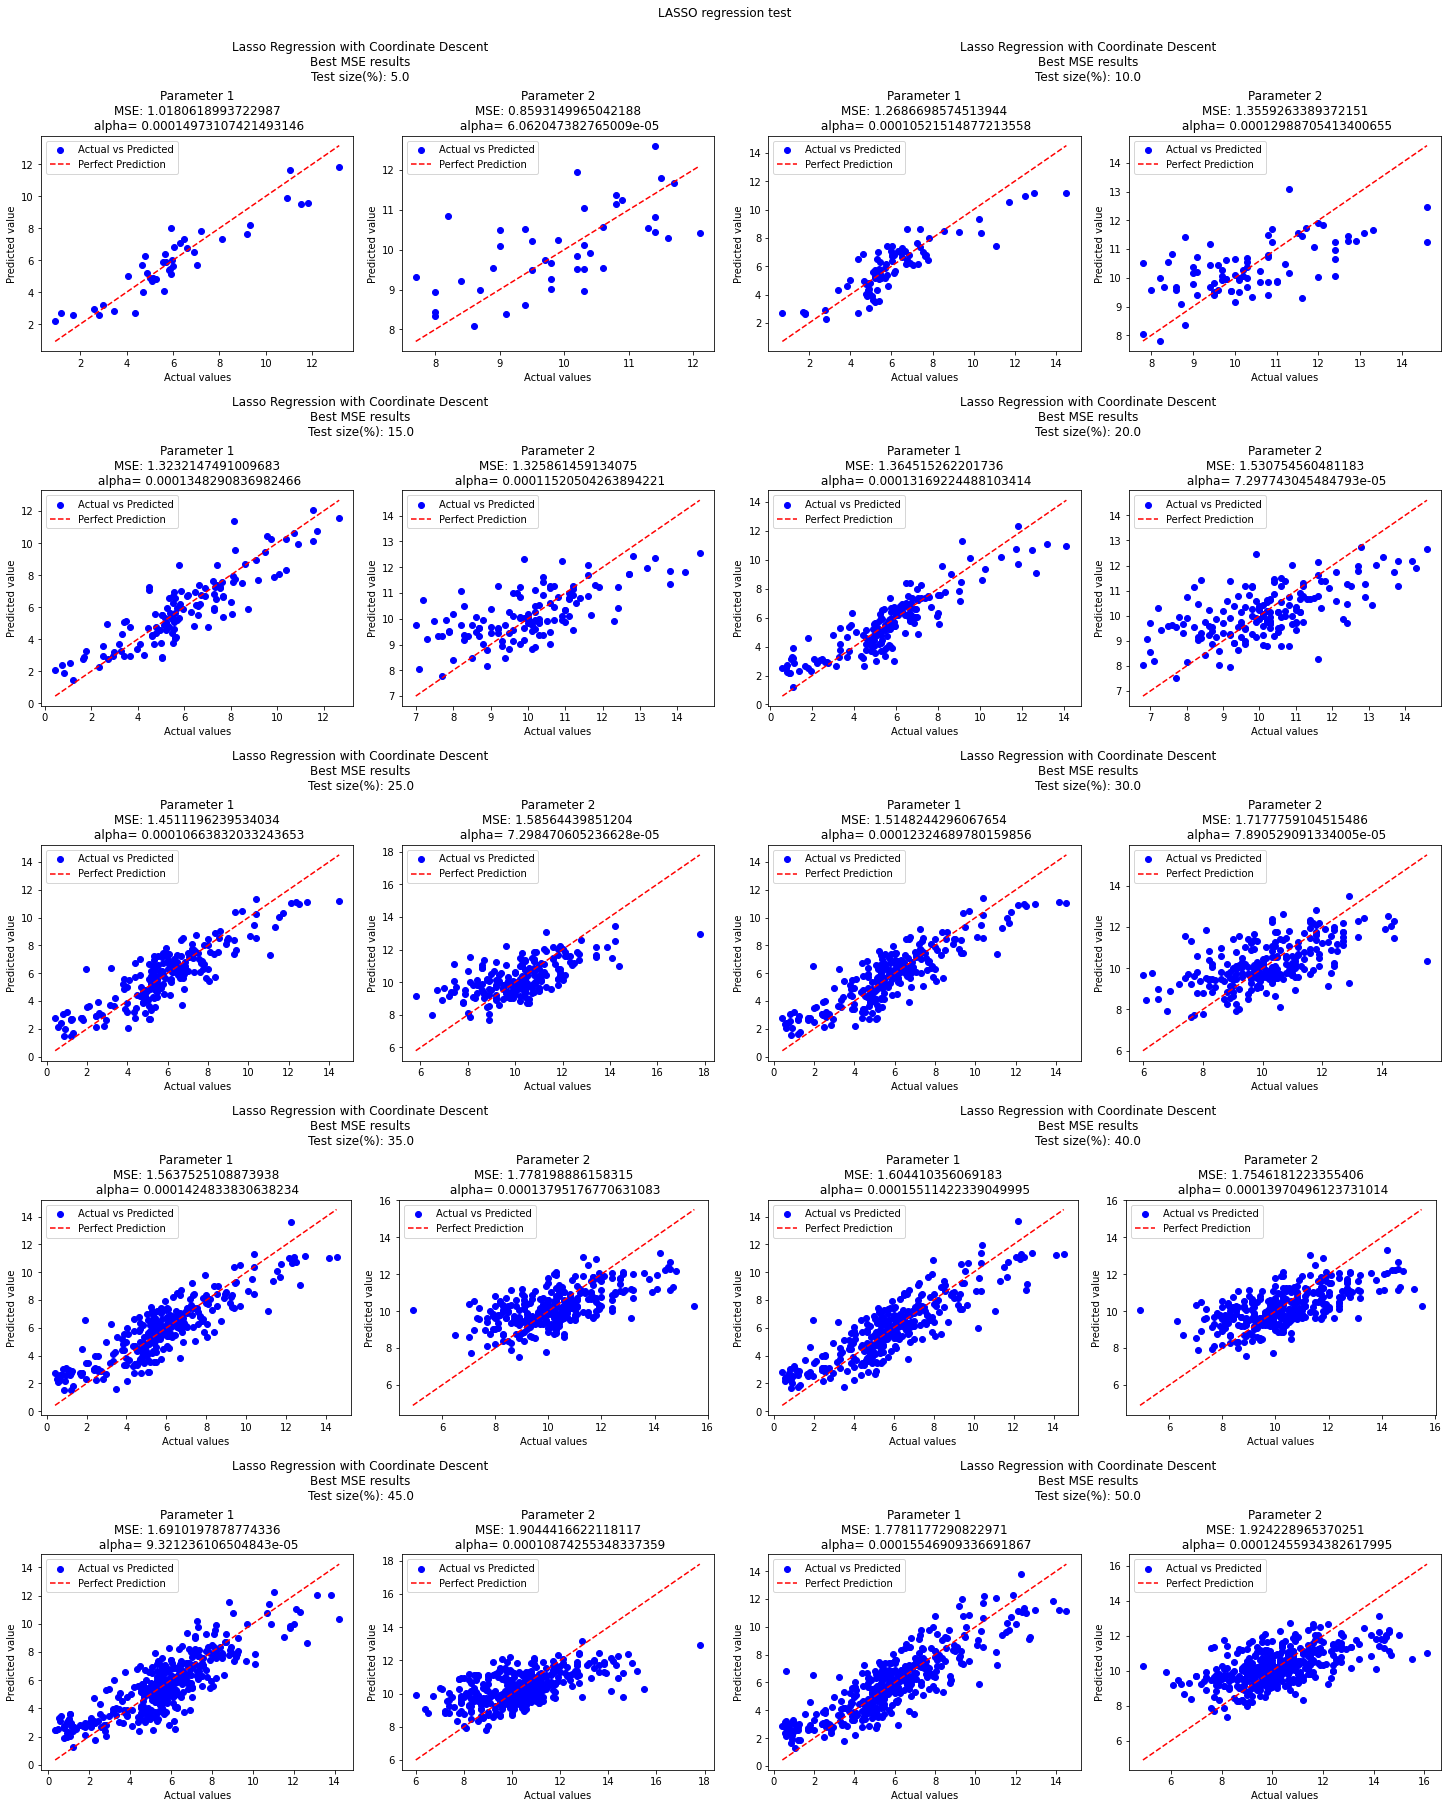

In [ ]:
mlflow.set_experiment("Lasso CD genetics")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i / 100 for i in range(5, 55, 5)]
results = []  

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('LASSO regression test' + "\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0




'''Param 1'''

for ripartition in ripartisions:


    MSE_param1 = []
    best_MSE_1 = 100000000
    best_data_1 = {"Y_test": None, "Y_pred": None, "seed": None,"alpha":None}


    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
    
        i = 0
        for i in range(trials):
            print("Ripartion: " + str(ripartition) + " - trial: " + str(i))
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:, 0], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_cd = Lasso(max_iter=5000, tol=1e-2)
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_reg_cd,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
                best_MSE_1 = MSE_param1[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_cd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        mlflow.log_metric("alpha1", best_data_1["alpha"])



        MSE_param2 = []
        best_MSE_2 = 100000000
        best_data_2 = {"Y_test": None, "Y_pred": None, "seed": None, "alpha":None}
        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:, 1], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_cd = Lasso(max_iter=5000, tol=1e-2)
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_reg_cd,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.predict(X_test)
    
            #save MSE of the second parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
                best_MSE_2 = MSE_param2[-1]
                best_data_2["Y_test"] = Y_test
                best_data_2["Y_pred"] = Y_pred_lasso_cd
                best_data_2["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_2["seed"] = seeds[i]

            
       
        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        mlflow.log_metric("alpha2", best_data_2["alpha"])
            
    results.append([str(ripartition * 100), str(best_MSE_1), str(best_MSE_2),
                    (np.mean(MSE_param1)), str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2)),
                    str(best_data_1["alpha"]), str(best_data_2["alpha"]), best_data_1["seed"],best_data_2["seed"]])

    
    '''PLOT THE BEST MODELS'''
    subfigs[k].suptitle(
        "Lasso Regression with Coordinate Descent" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    # create 1x2 subplots per subfig
    axs = subfigs[k].subplots(nrows=1, ncols=2)
    axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[0].legend()
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted value")
    axs[0].set_title(
        "Parameter 1" + "\n" + "MSE: " + str(min(MSE_param1)) + "\n" + " alpha= " + str(best_data_1["alpha"]))

    axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[1].legend()
    axs[1].set_xlabel("Actual values")
    axs[1].set_ylabel("Predicted value")
    axs[1].set_title(
        "Parameter 2" + "\n" + "MSE: " + str(min(MSE_param2)) + "\n" + " alpha= " + str(best_data_2["alpha"]))
    k += 1


'''SHOW RESULTS'''
headers = ["Test size(%)", "Best(MSE1)", "Best(MSE2)", "Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)",
           "alpha1","alpha2","Seed1","Seed2"]

print(tabulate(results, headers, tablefmt="double_outline"))




**LASSO with coordinate descent NRMSEPiqr**

0.25 ripartition
Trial:  1
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.626136	0.146132   	-0.347267  	-0.830146  
1  	20    	-0.501282	0.109888   	-0.347267  	-0.614123  
2  	20    	-0.454771	0.120398   	-0.347267  	-0.744172  
3  	20    	-0.373778	0.0438025  	-0.326139  	-0.463323  
4  	20    	-0.353045	0.0257728  	-0.326139  	-0.424397  
5  	20    	-0.341829	0.0116493  	-0.326139  	-0.354472  
6  	20    	-0.401475	0.115005   	-0.321761  	-0.625227  
7  	20    	-0.37994 	0.100602   	-0.321761  	-0.608626  
8  	20    	-0.376424	0.0951978  	-0.321761  	-0.612928  
9  	20    	-0.328314	0.00712791 	-0.321761  	-0.342012  
10 	20    	-0.38481 	0.115057   	-0.321761  	-0.630221  
0.5 ripartition
Trial:  1
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.670632	0.122904   	-0.409986  	-0.842855  
1  	20    	-0.589771	0.113619   	-0.409986  	-0.774126  
2  	20    	-0.513539	0.100013   	-0.409986  	-0.651605  
3  	20    	-0.598773	0.0758045  	-0

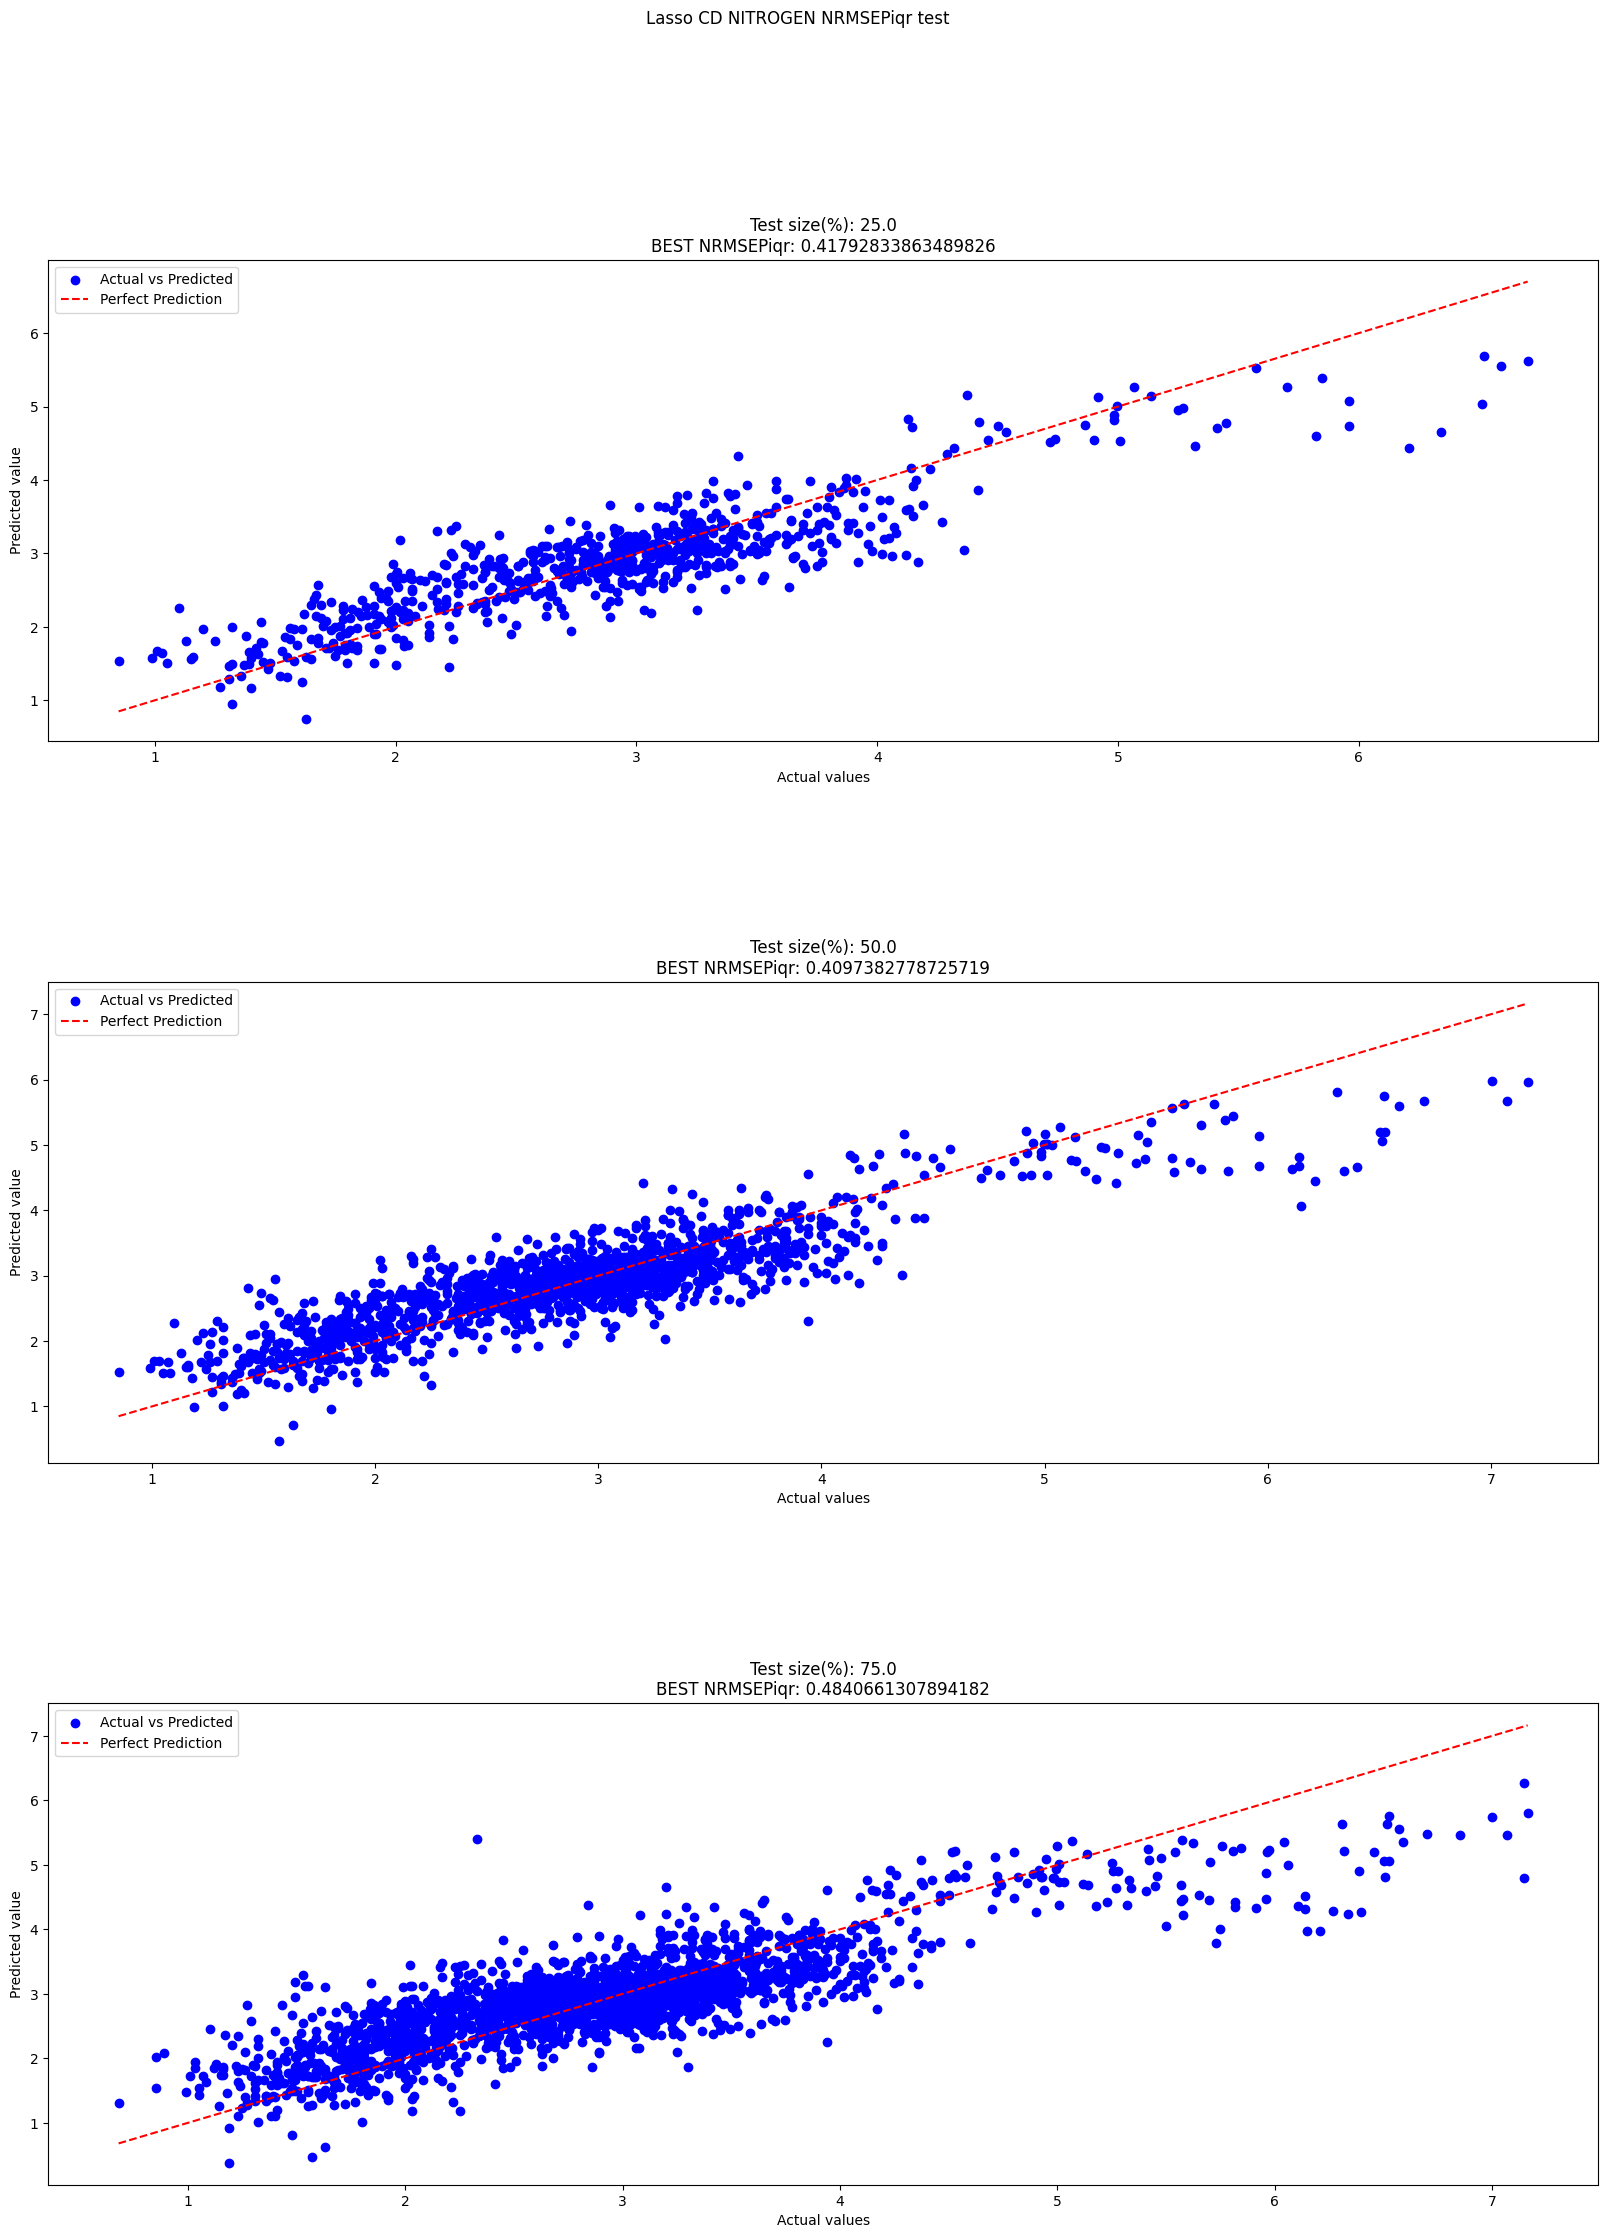

In [7]:
from sklearn.metrics import make_scorer

def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr)


def MSE(observed_values, predicted_values):
    squared_differences = [(yt-yp)**2 for yt, yp in zip(observed_values,predicted_values)]

    sum_squared_differences = sum(squared_differences)

    return -(sum_squared_differences/ len(observed_values))


MSEscorer = make_scorer(MSE)

mlflow.set_experiment("Lasso CD NITROGEN genetics NRMSEPiqr")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 1
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso CD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0




'''NITROGEN'''

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}



    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_cd = Lasso(max_iter=5000, tol=1e-2)
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_reg_cd,
                              cv=5,
                              scoring=MSEscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.best_estimator_.predict(X_test)
    
            
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_cd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]

        
        mlflow.log_metric("Best_NRMSEPiqr", best_NRMSEP)
        mlflow.log_metric("Mean_NRMSEPiqr", np.mean(NRMSEP))
        mlflow.log_metric("Var_NRMSEPiqr", np.var(NRMSEP))
        mlflow.log_metric("alpha", best_data_1["alpha"])
        mlflow.log_metric("seed", best_data_1["seed"])



    results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))




**LASSO with SGD**

In [ ]:
mlflow.set_experiment("Lasso SGD genetics Nitrogen MSE")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso SGD NITROGEN MSE test'+"\n")
axs = axs.flatten()
k = 0


for ripartition in ripartisions:

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    

    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        print(run_name)

        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l1", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=lasso_reg_sgd,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10)
    
            #grid search will contain the best model
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_sgd =  evolved_estimator.predict(X_test)
    
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_lasso_sgd))
    
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_lasso_sgd
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
        
        mlflow.log_metric("Best_MSE", best_MSE_1)
        mlflow.log_metric("Mean_MSE", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE", np.var(MSE_param1))
        mlflow.log_metric("alpha", best_data_1["alpha"])
        mlflow.log_metric("seed", best_data_1["seed"])
        
    results.append([str(ripartition *100 ), str(best_MSE_1),
                    (np.mean(MSE_param1)), str(np.var(MSE_param1)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE)", "Mean(MSE)", "Var(MSE)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**LASSO with SGD NITROGEN**

0.25 ripartition
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.770849	0.0713632  	0.882073   	0.637105   
1  	20    	0.8523  	0.0326525  	0.882073   	0.768962   
2  	20    	0.836499	0.0416772  	0.882073   	0.780428   
3  	20    	0.860445	0.0311791  	0.882073   	0.780428   
4  	20    	0.856921	0.0360795  	0.882073   	0.780428   
5  	20    	0.856007	0.0302287  	0.882073   	0.791261   
6  	20    	0.86029 	0.0241189  	0.880233   	0.821968   
7  	20    	0.869749	0.0164647  	0.880233   	0.821968   
8  	20    	0.870449	0.015949   	0.876777   	0.82329    
9  	20    	0.870181	0.0118714  	0.876777   	0.839136   
10 	20    	0.87219 	0.0113769  	0.878833   	0.839136   
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.819974	0.0495346  	0.879452   	0.755479   
1  	20    	0.851942	0.0402     	0.882712   	0.778267   
2  	20    	0.867904	0.0183579  	0.882712   	0.823874   
3  	20    	0.856887	0.0313681  	0.882712   	0.797754   
4  	20    	0.873997	0.0167905  

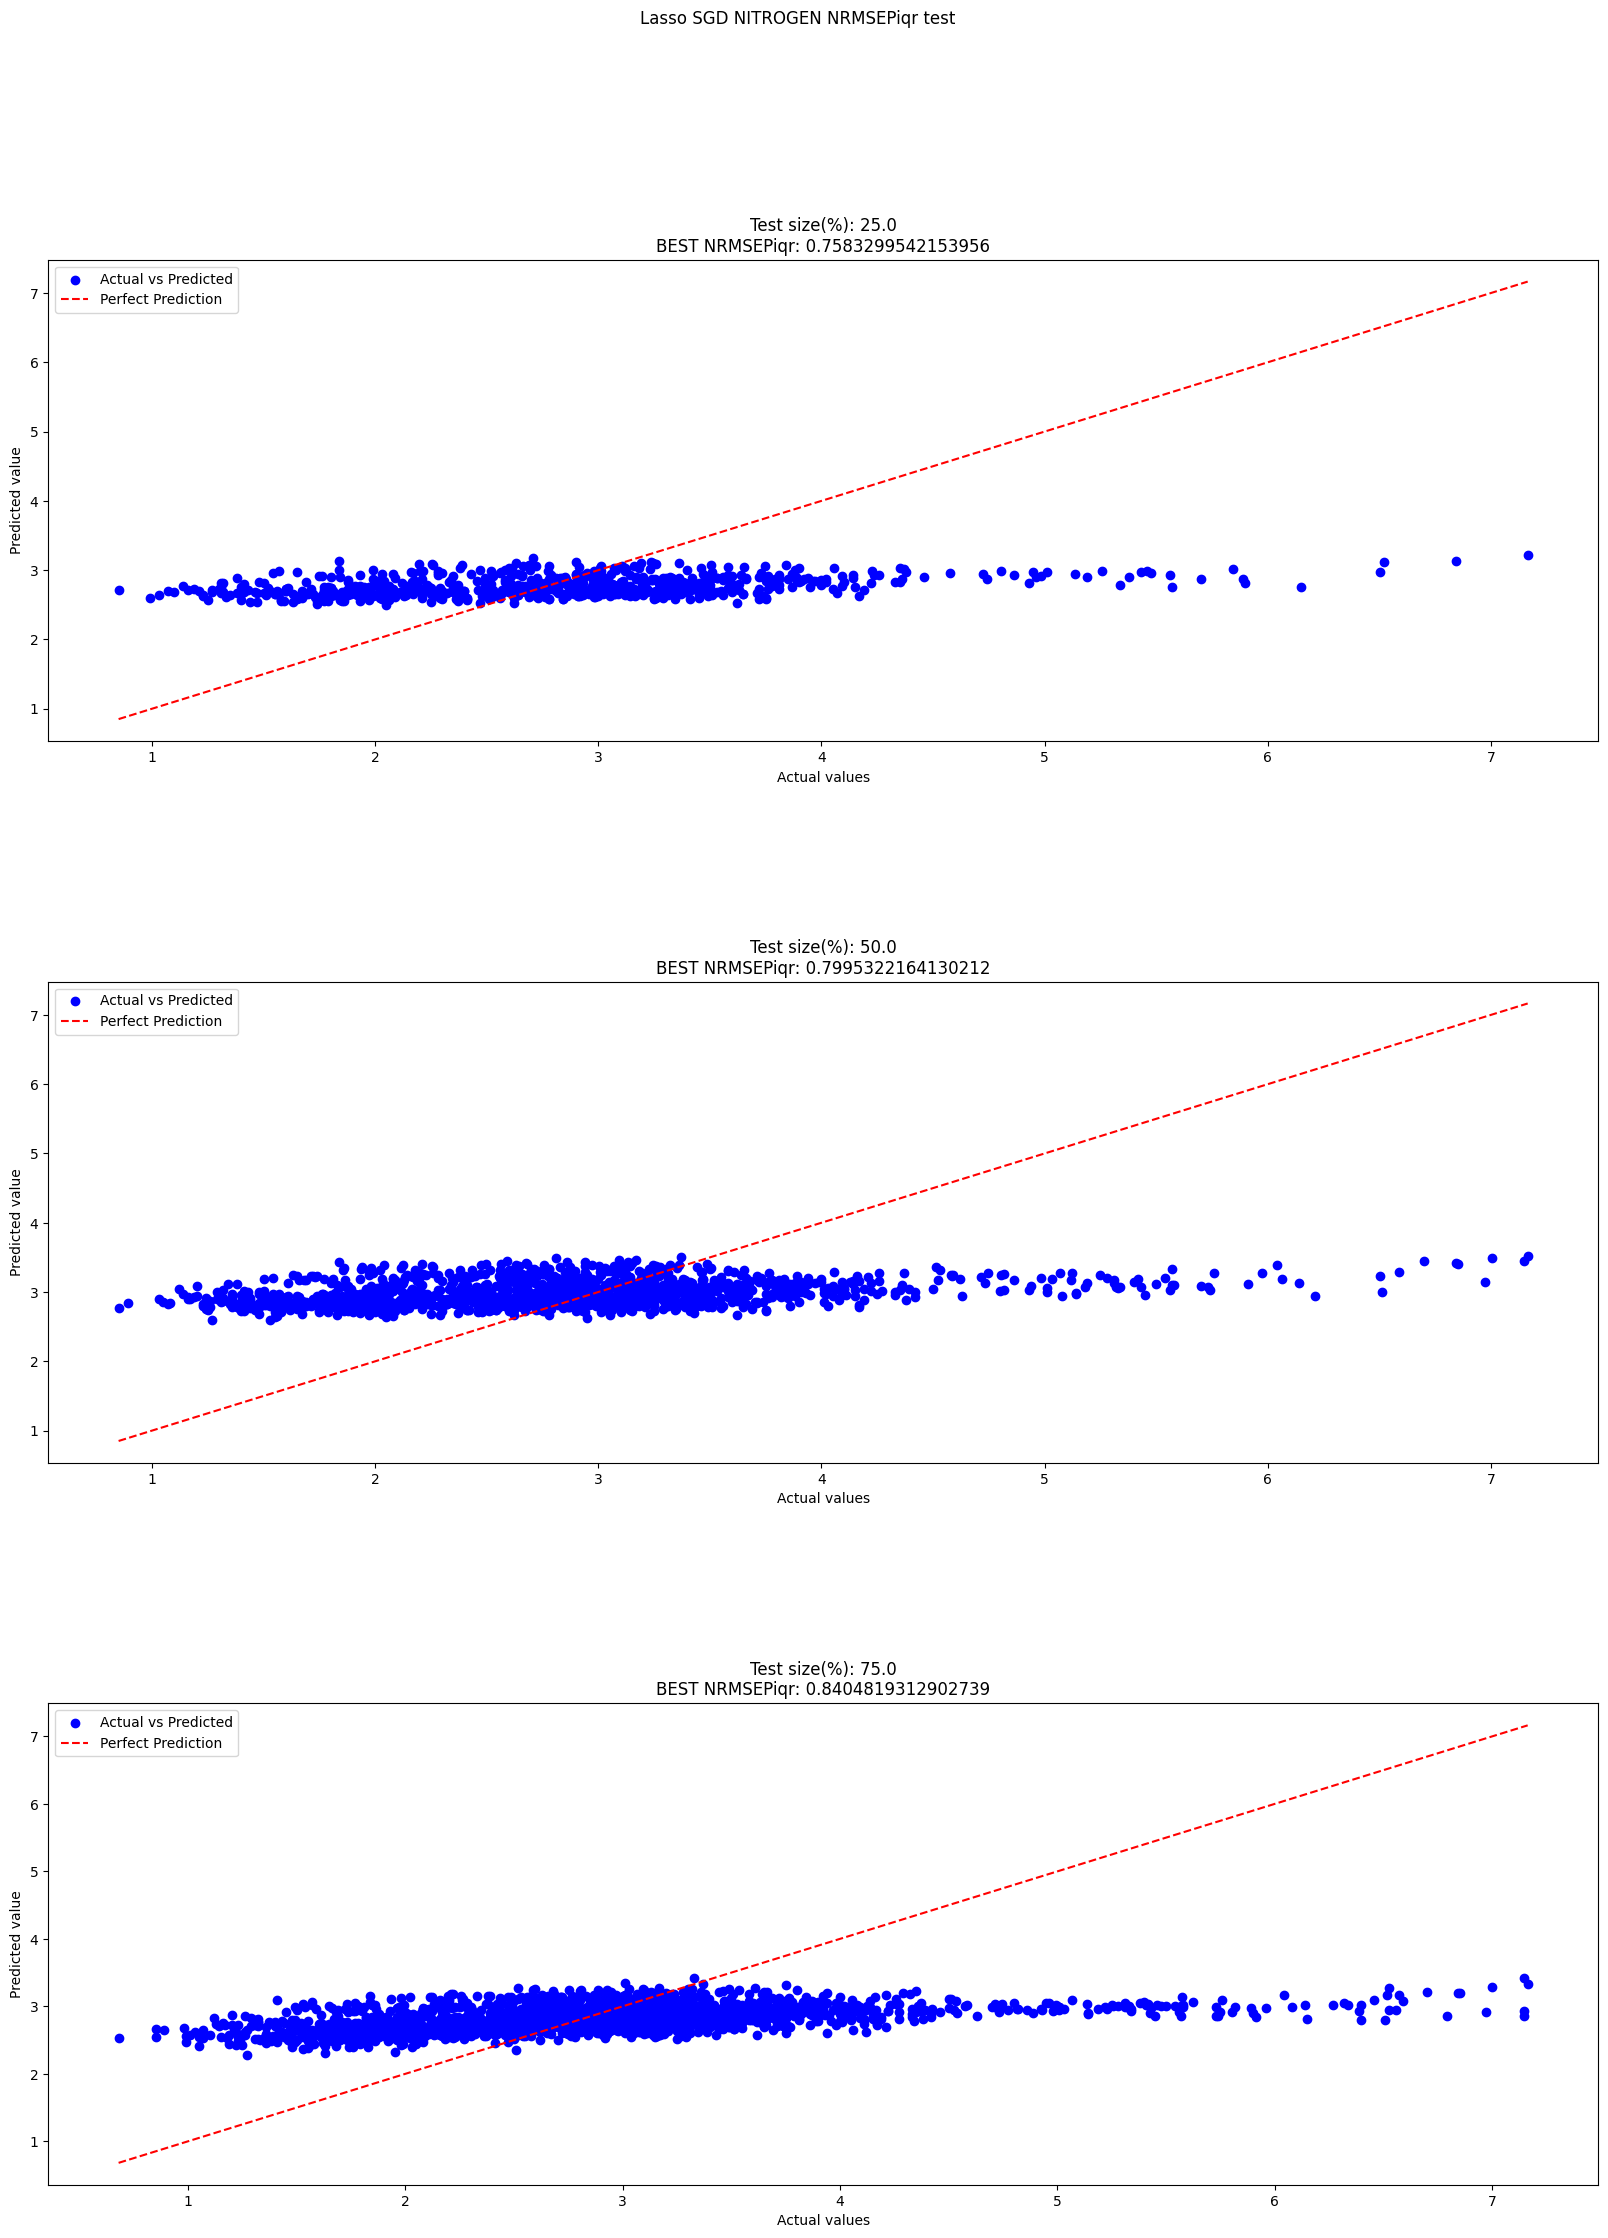

In [14]:
mlflow.set_experiment("Lasso SGD genetics Nitrogen")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0


for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    

    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        print(run_name)

        i = 0
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l1", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=lasso_reg_sgd,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            #grid search will contain the best model
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_sgd =  evolved_estimator.predict(X_test)
    
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_lasso_sgd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_sgd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]

        
        mlflow.log_metric("Best_NRMSEPiqr", best_NRMSEP)
        mlflow.log_metric("Mean_NRMSEPiqr", np.mean(NRMSEP))
        mlflow.log_metric("Var_NRMSEPiqr", np.var(NRMSEP))
        mlflow.log_metric("alpha", best_data_1["alpha"])
        mlflow.log_metric("seed", best_data_1["seed"])
        
    results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))


